# Centering Images

## Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import nibabel as nb
from nilearn import plotting

In [66]:
from scipy import ndimage

In [4]:
DATA_DIR = 'data'

## Explore background mask

In [5]:
bkg = nb.load(os.path.join(DATA_DIR, '27cd6b8c7e8049edb874f9664c54f857_reorient-background.nii.gz'))

In [6]:
bkg_np = np.asanyarray(bkg.dataobj)

In [7]:
bkg_np.shape

(512, 512, 541)

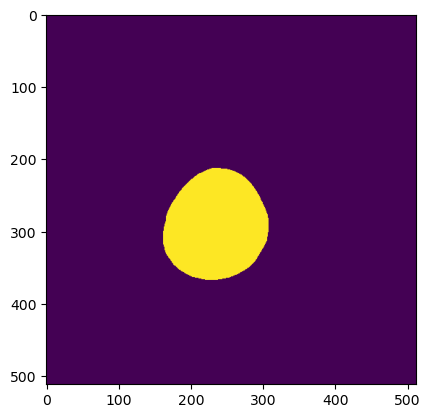

In [14]:
plt.imshow(bkg_np[:, :, 0])

In [15]:
ys, xs = np.where(bkg_np[:,:,0])

In [21]:
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

In [23]:
x_c = (x_min + x_max) // 2
y_c = (y_min + y_max) // 2

In [25]:
x_c

np.int64(234)

In [26]:
y_c

np.int64(290)

In [27]:
def find_centroid(image):
    ys, xs = np.where(image)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    x_c = (x_min + x_max) // 2
    y_c = (y_min + y_max) // 2

    return y_c, x_c

In [74]:
def find_centroid(image):
    y_c, x_c = ndimage.center_of_mass(image)
    return int(y_c), int(x_c)

In [75]:
find_centroid(bkg_np[:,:,0])

(292, 234)

In [68]:
y_c, x_c = np.array([find_centroid(bkg_np[:, :, i]) for i in range(bkg_np.shape[2])]).T

In [48]:
bkg_np.shape[0] // 2, bkg_np.shape[1] // 2

(256, 256)

In [76]:
def translate_image(image, dy, dx):
    translated = np.roll(image, dy, axis=0)
    translated = np.roll(translated, dx, axis=1)
    return translated

In [80]:
256 - 292

-36

In [81]:
def center_image(image_seq):
    y_c, x_c = np.array([find_centroid(image_seq[:, :, i]) for i in range(image_seq.shape[2])]).T
    y_c_im, x_c_im = image_seq.shape[0] // 2, image_seq.shape[1] // 2

    dx = x_c_im - x_c
    dy = y_c_im - y_c

    translated_seq = np.stack(
        [translate_image(image_seq[:, :, i], dy[i], dx[i]) for i in range(image_seq.shape[2])],
        axis=-1
    )

    return translated_seq

In [82]:
centered_bkg = center_image(bkg_np)

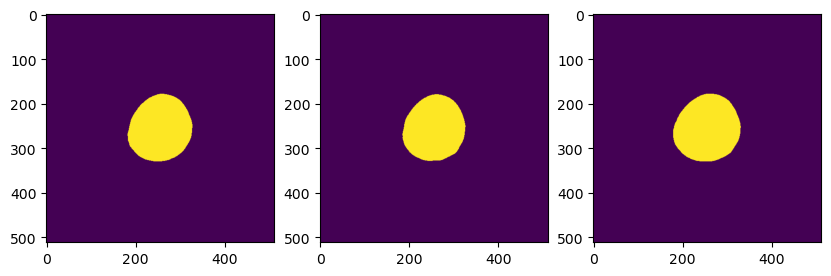

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(10, 15))

for i, ax in enumerate(ax):
    ax.imshow(centered_bkg[:, :, i+3])

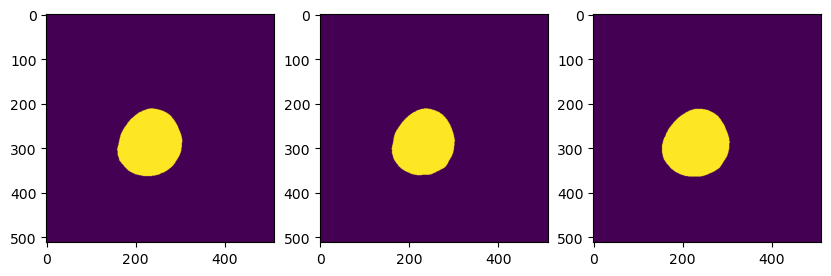

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(10, 15))

for i, ax in enumerate(ax):
    ax.imshow(bkg_np[:, :, i+3])